In [32]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [34]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [35]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [36]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [37]:
ims = search_images_ddg('pants', max_images = 600)
len(ims)

600

In [38]:
dest = 'images/pants.jpg'
download_url(ims[0], dest, show_progress = False)

Path('images/pants.jpg')

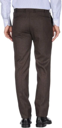

In [39]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [43]:
clothe_types = 'shirt', 'pants'
path = Path('clothes')

In [46]:
if not path.exists():
    path.mkdir()
    for o in clothe_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_ddg(f'{o}')
        download_images(dest, urls=results)

In [47]:
fns = get_image_files(path)
fns

(#0) []

In [17]:
failed = verify_images(fns)
failed

(#0) []

In [18]:
failed.map(Path.unlink)

(#0) []

In [19]:
clothe = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 0),
    get_y = parent_label,
    item_tfms = Resize(128))

In [20]:
clothe = clothe.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = clothe.dataloaders(path)
dls.train.show_batch(max_n = 4, nrows = 1)

TypeError: 'NoneType' object is not iterable

In [ ]:
citrus = citrus.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3))
dls = citrus.dataloaders(path)
dls.train.show_batch(max_n = 4, nrows = 1, unique = True)

In [ ]:
citrus = citrus.new(item_tfms = Resize(128),
                   batch_tfms = aug_transforms(mult = 2))
dls = citrus.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [ ]:
citrus = citrus.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms())
dls = citrus.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(10, nrows =2, figsize = (17, 4))

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export('model.pkl')

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import push_to_hub_fastai

repo_id = "tompham97/citrus-fruit-classifier"

push_to_hub_fastai(learner = learn, repo_id = repo_id)